![Animal Crossing: New Horizons official art](images/AnimalCrossingNewHorizons.jpg)
*Source: [Nintendo Life](https://nintendosoup.com/animal-crossing-new-horizons-full-official-artwork-revealed/)*

# Predicting Sentiment of Animal Crossing: New Horizons Reviews

## Introduction

I wanted to take on this dataset for analysis because I myself played Animal Crossing: New Horizons during the early days of the pandemic. It gave me something to do and I enjoyed it at the time, but I myself stopped playing after 9 months. Obviously, I didn’t have the same experience as others, and because of that it inspired me to research what other people thought of the game at the time and determine what the general consensus is surrounding this game, which led me to center this project around reviews for Animal Crossing: New Horizons.

This project consists of two parts: the creation of a machine learning model using the scikit-learn library that can perform an optimized sentiment rating on reviews for Animal Crossing: New Horizons and the deployment of that model to create an application that can predict the sentiment of a review for this game based on a pure review of the game.

## Business Problem

Animal Crossing: New Horizons is one of the Nintendo Switch's best entries, having sold 33.89 million copies [(as of June 30, 2021)](https://www.nintendo.co.jp/ir/en/finance/software/index.html) and is the second-best selling game in the console's history. Having released during the beginning the COVID-19 pandemic, it served as a cultural icon and played a major part in driving Switch sales. However, since the beginning it has been a growing topic of controversy and debate. Fans of the franchise would (and still do) comment about how lackluster its features were compared to past titles, while others just become burnt out and bored quickly due to the lack of content.

If I were given the task to help Nintendo's dev team figure out new updates for New Horizons or help contribute ideas for the next title in the Animal Crossing series, I would want to look at reviews and feedback surrounding New Horizons to let them know what they did well and what they could improve on. To do this, first I create and test a machine learning model using modules from the scikit-learn library that can accurately predict a user's review sentiment based on the content in the review. We can then use the best model from our test models and create an application where users can input their own reviews for the game and receive a prediction for the sentiment of their review. This would allow us to use the feedback collected from the users who submitted reviews to further investigate what we did well and what we can improve on in later titles.

## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from nltk.corpus import stopwords
from nltk import word_tokenize, regexp_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import string
import re

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

### Exploring the data

The data used comes from Jesse Mostipak on Kaggle and contains reviews from Metacritic from critics and users of the site that submitted reviews for Animal Crossing: New Horizons. Since we are primarily concerned with the opinions of our playerbase, we will only be using the `user_reviews.csv` file, which can be accessed from the project repository's `data` folder.

In [2]:
user_df = pd.read_csv('data/user_reviews.csv')
user_df.head()

,grade,user_name,text,date
0,4,mds27272,My gf started playing before me. No option to ...,2020-03-20
1,5,lolo2178,"While the game itself is great, really relaxin...",2020-03-20
2,0,Roachant,My wife and I were looking forward to playing ...,2020-03-20
3,0,Houndf,We need equal values and opportunities for all...,2020-03-20
4,0,ProfessorFox,BEWARE! If you have multiple people in your h...,2020-03-20


Dropping the `user_name` column of the dataframe so we can more easily focus on the most important components,
we investigate the logistics of the data:

In [3]:
user_df = user_df.drop(['user_name'], axis=1)
print(user_df.info())
user_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   grade   2999 non-null   int64 
 1   text    2999 non-null   object
 2   date    2999 non-null   object
dtypes: int64(1), object(2)
memory usage: 70.4+ KB
None


,grade,text,date
0,4,My gf started playing before me. No option to ...,2020-03-20
1,5,"While the game itself is great, really relaxin...",2020-03-20
2,0,My wife and I were looking forward to playing ...,2020-03-20
3,0,We need equal values and opportunities for all...,2020-03-20
4,0,BEWARE! If you have multiple people in your h...,2020-03-20
...,...,...,...
2994,1,1 Island for console limitation.I cannot play ...,2020-05-03
2995,1,"Per giocare con figli o fidanzate, mogli o per...",2020-05-03
2996,0,One island per console is a pathetic limitatio...,2020-05-03
2997,2,Even though it seems like a great game with ma...,2020-05-03


Looking at a distribution of scores that the users gave the game within the time range of these reviews (March 2020-May 2020), it seems that the reviews were heavily polarized; a majority of users seemed to either love or hate the game.

<AxesSubplot:>

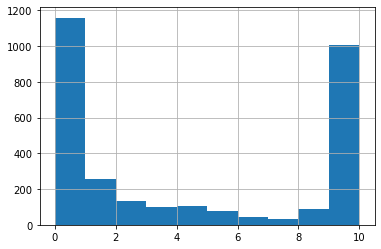

In [4]:
user_df['grade'].hist()

### Tokenization with NLTK

Tokenizing text

In [5]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)" # defining pattern so tokenizer recognizes apostrophes as one word

user_df['tokens_raw'] = [regexp_tokenize(text, pattern) for text in user_df['text']]

user_df['tokens_raw']

0       [My, gf, started, playing, before, me, No, opt...
1       [While, the, game, itself, is, great, really, ...
2       [My, wife, and, I, were, looking, forward, to,...
3       [We, need, equal, values, and, opportunities, ...
4       [BEWARE, If, you, have, multiple, people, in, ...
                              ...                        
2994    [Island, for, console, limitation, I, cannot, ...
2995    [Per, giocare, con, figli, o, fidanzate, mogli...
2996    [One, island, per, console, is, a, pathetic, l...
2997    [Even, though, it, seems, like, a, great, game...
2998    [Game, is, fantastic, Nintendo, deciding, that...
Name: tokens_raw, Length: 2999, dtype: object

Lowercasing text

In [6]:
user_df['tokens'] = user_df['tokens_raw'].apply(lambda x: [word.lower() for word in x])
user_df.head()

,grade,text,date,tokens_raw,tokens
0,4,My gf started playing before me. No option to ...,2020-03-20,"[My, gf, started, playing, before, me, No, opt...","[my, gf, started, playing, before, me, no, opt..."
1,5,"While the game itself is great, really relaxin...",2020-03-20,"[While, the, game, itself, is, great, really, ...","[while, the, game, itself, is, great, really, ..."
2,0,My wife and I were looking forward to playing ...,2020-03-20,"[My, wife, and, I, were, looking, forward, to,...","[my, wife, and, i, were, looking, forward, to,..."
3,0,We need equal values and opportunities for all...,2020-03-20,"[We, need, equal, values, and, opportunities, ...","[we, need, equal, values, and, opportunities, ..."
4,0,BEWARE! If you have multiple people in your h...,2020-03-20,"[BEWARE, If, you, have, multiple, people, in, ...","[beware, if, you, have, multiple, people, in, ..."


Removing stopwords

In [7]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['game', 'animal', 'crossing']
user_df['no_stops'] = user_df['tokens'].apply(lambda x: [w for w in x if w not in stopwords_list])

user_df.head()

,grade,text,date,tokens_raw,tokens,no_stops
0,4,My gf started playing before me. No option to ...,2020-03-20,"[My, gf, started, playing, before, me, No, opt...","[my, gf, started, playing, before, me, no, opt...","[gf, started, playing, option, create, island,..."
1,5,"While the game itself is great, really relaxin...",2020-03-20,"[While, the, game, itself, is, great, really, ...","[while, the, game, itself, is, great, really, ...","[great, really, relaxing, gorgeous, can't, ign..."
2,0,My wife and I were looking forward to playing ...,2020-03-20,"[My, wife, and, I, were, looking, forward, to,...","[my, wife, and, i, were, looking, forward, to,...","[wife, looking, forward, playing, released, bo..."
3,0,We need equal values and opportunities for all...,2020-03-20,"[We, need, equal, values, and, opportunities, ...","[we, need, equal, values, and, opportunities, ...","[need, equal, values, opportunities, players, ..."
4,0,BEWARE! If you have multiple people in your h...,2020-03-20,"[BEWARE, If, you, have, multiple, people, in, ...","[beware, if, you, have, multiple, people, in, ...","[beware, multiple, people, house, want, play, ..."


Creating frequency distribution of words among reviews

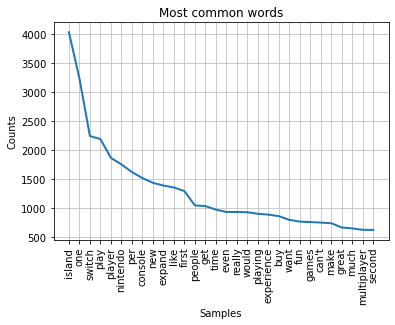

<AxesSubplot:title={'center':'Most common words'}, xlabel='Samples', ylabel='Counts'>

In [8]:
# for token_list in user_df['no_stops']:
#     token_list = ' '.join(token_list)
#     token_list = token_list.split(' ')
test = user_df.no_stops.explode().to_list()
fdist = FreqDist(test)
fdist.plot(30, title='Most common words')

# # user_freqdist = FreqDist(user_df['tokens_raw'])
# # user_freqdist.most_common(50)

### Labeling the data

Assigning "positive" and "negative" labels to data based on score threshold defined on Metacritic's review page for this game. For reference:
- 8-10 is "positive"
- 5-7 is "neutral"
- 0-4 is "negative"

https://www.metacritic.com/game/switch/animal-crossing-new-horizons/user-reviews

In [9]:
def sentiment_labels(row):
    if row['grade'] >= 8:
        val = 'positive'
    elif row['grade'] <= 4:
        val = 'negative'
    else:
        val = 'neutral'
    return val

In [10]:
user_df['sentiment'] = user_df.apply(sentiment_labels, axis=1)
user_df

,grade,text,date,tokens_raw,tokens,no_stops,sentiment
0,4,My gf started playing before me. No option to ...,2020-03-20,"[My, gf, started, playing, before, me, No, opt...","[my, gf, started, playing, before, me, no, opt...","[gf, started, playing, option, create, island,...",negative
1,5,"While the game itself is great, really relaxin...",2020-03-20,"[While, the, game, itself, is, great, really, ...","[while, the, game, itself, is, great, really, ...","[great, really, relaxing, gorgeous, can't, ign...",neutral
2,0,My wife and I were looking forward to playing ...,2020-03-20,"[My, wife, and, I, were, looking, forward, to,...","[my, wife, and, i, were, looking, forward, to,...","[wife, looking, forward, playing, released, bo...",negative
3,0,We need equal values and opportunities for all...,2020-03-20,"[We, need, equal, values, and, opportunities, ...","[we, need, equal, values, and, opportunities, ...","[need, equal, values, opportunities, players, ...",negative
4,0,BEWARE! If you have multiple people in your h...,2020-03-20,"[BEWARE, If, you, have, multiple, people, in, ...","[beware, if, you, have, multiple, people, in, ...","[beware, multiple, people, house, want, play, ...",negative
...,...,...,...,...,...,...,...
2994,1,1 Island for console limitation.I cannot play ...,2020-05-03,"[Island, for, console, limitation, I, cannot, ...","[island, for, console, limitation, i, cannot, ...","[island, console, limitation, cannot, play, gi...",negative
2995,1,"Per giocare con figli o fidanzate, mogli o per...",2020-05-03,"[Per, giocare, con, figli, o, fidanzate, mogli...","[per, giocare, con, figli, o, fidanzate, mogli...","[per, giocare, con, figli, fidanzate, mogli, p...",negative
2996,0,One island per console is a pathetic limitatio...,2020-05-03,"[One, island, per, console, is, a, pathetic, l...","[one, island, per, console, is, a, pathetic, l...","[one, island, per, console, pathetic, limitati...",negative
2997,2,Even though it seems like a great game with ma...,2020-05-03,"[Even, though, it, seems, like, a, great, game...","[even, though, it, seems, like, a, great, game...","[even, though, seems, like, great, many, items...",negative


Investigating class balance

In [11]:
user_df['sentiment'].value_counts()

negative    1747
positive    1096
neutral      156
Name: sentiment, dtype: int64

In [12]:
user_df['sentiment'].value_counts(normalize=True)

negative    0.582528
positive    0.365455
neutral     0.052017
Name: sentiment, dtype: float64

Significant class imbalance, there are far more negative reviews than positive/neutral.

<AxesSubplot:>

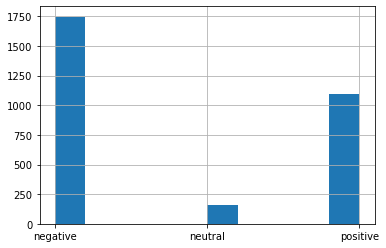

In [13]:
user_df['sentiment'].hist()

## Preprocessing

Lemmatizing words

In [14]:
lemmatizer = WordNetLemmatizer()
user_df['lemmatized'] = user_df['no_stops'].apply(lambda x:[lemmatizer.lemmatize(w) for w in x])
user_df['lemmatized']

0       [gf, started, playing, option, create, island,...
1       [great, really, relaxing, gorgeous, can't, ign...
2       [wife, looking, forward, playing, released, bo...
3       [need, equal, value, opportunity, player, isla...
4       [beware, multiple, people, house, want, play, ...
                              ...                        
2994    [island, console, limitation, cannot, play, gi...
2995    [per, giocare, con, figli, fidanzate, mogli, p...
2996    [one, island, per, console, pathetic, limitati...
2997    [even, though, seems, like, great, many, item,...
2998    [fantastic, nintendo, deciding, make, one, isl...
Name: lemmatized, Length: 2999, dtype: object

Training and test set split

In [15]:
X = user_df['lemmatized'].str.join(' ')
y = user_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## Analysis

- TF-IDF vectorizer to convert our text data into binary vectors that our classifiers can process
- Because our categories are imbalanced, to prevent overfitting we resample our data using SMOTE and define a sampling strategy to ensure SMOTE resamples all classes except our majority class
- Pipeline is created to prevent data leakage
- Model is scored by cross-validation and recall (we want to identify how well model is able to predict true positives)

In [16]:
def text_classification(model):
    """
    Takes in a scikit-learn classifier and runs a model
    based on the training data provided. Returns cross-validated
    scores and an average score rating the performance of the model.
    Also returns a confusion matrix as a visual representation
    of the model's accuracy.
    """
    tfidf_vectorizer = TfidfVectorizer()
    smote = SMOTE(sampling_strategy='not majority')
    
    pipeline = make_pipeline(tfidf_vectorizer, smote, model)
    
    scores = cross_val_score(pipeline, X_train, y_train)
    print('Cross-validated scores:', scores.round(3))
    print('Average CV score:', np.mean(scores).round(3))
    
    pipeline.fit(X_train, y_train)
    y_preds = pipeline.predict(X_test)
    print('Recall score:', recall_score(y_test, y_preds, average='micro').round(3))
    
    plot_confusion_matrix(pipeline, X_test, y_test)
    
    return pipeline

First model is simple machine learning model, logistic regression model

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Cross-validated scores: [0.833 0.835 0.8   0.827 0.818]
Average CV score: 0.823
Recall score: 0.828


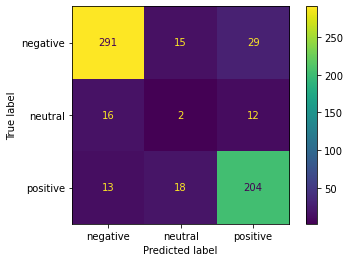

In [17]:
logreg_model = LogisticRegression()
logreg_pipe = text_classification(logreg_model)

Next model is Naive Bayes, goes off of statistical Bayes' theorem. There are multiple iterations of the Naive Bayes classifier, multinomial Naive Bayes is the most suitable for text classification

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

Cross-validated scores: [0.673 0.688 0.675 0.74  0.733]
Average CV score: 0.702
Recall score: 0.683


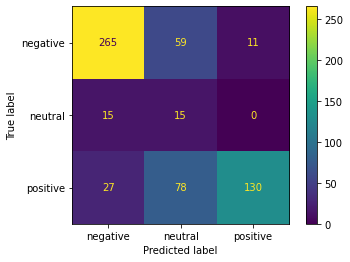

In [18]:
mnb_model = MultinomialNB()
mnb_pipe = text_classification(mnb_model)

Decision tree classifier
- Another simple classifier that revolves around the idea of predicting the value of a target variable using decision rules inferred from the data features. The concept of this model matches well with the idea behind our model (using key words to predict the sentiment of a review)

https://scikit-learn.org/stable/modules/tree.html

Cross-validated scores: [0.66  0.625 0.642 0.671 0.674]
Average CV score: 0.654
Recall score: 0.62


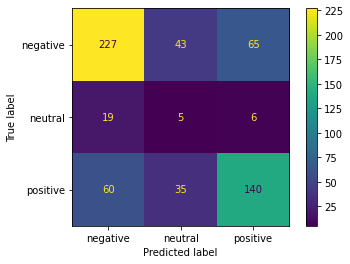

In [19]:
dt_model = DecisionTreeClassifier(max_depth=5)
dt_pipe = text_classification(dt_model)

Random forest classifier (averaged ensemble of decision trees). Did better than decision tree model, however is not as good as logreg model.
- Ensemble method; derives from decision tree classifier. Unlike decision tree classifier, which creates a tree from the whole dataset, random forest takes subsets of the training set to create individual trees and averages all the trees to produce the most optimal predictive ability.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Cross-validated scores: [0.783 0.796 0.796 0.835 0.816]
Average CV score: 0.805
Recall score: 0.833


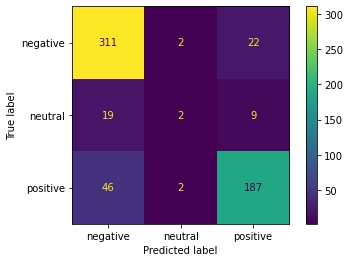

In [20]:
rf_model = RandomForestClassifier()
rf_pipe = text_classification(rf_model)

### Optimization

Grid search to find optimal parameters for best model. We will be performing a grid search on logistic regression model and random forest; had best cross-validation and recall scores. Even though logistic regression model slightly outperforms random forest, I am interested in seeing if an opimized random forest model will outperform an optimized logistic regression model.

To create the parameter grids to run the grid search on both models, I obtain the names of the parameters in each model and the values at which each parameter was at when the model was ran:

In [21]:
logreg_pipe.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()),
  ('smote', SMOTE(sampling_strategy='not majority')),
  ('logisticregression', LogisticRegression())],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'smote': SMOTE(sampling_strategy='not majority'),
 'logisticregression': LogisticRegression(),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pa

In [22]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()),
  ('smote', SMOTE(sampling_strategy='not majority')),
  ('randomforestclassifier', RandomForestClassifier())],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'smote': SMOTE(sampling_strategy='not majority'),
 'randomforestclassifier': RandomForestClassifier(),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvect

Using this information, I create the parameter grids and the values I wish to test during the grid search:

In [23]:
logreg_param_grid = {
    'logisticregression__penalty': ['none', 'l2', 'l1', 'elasticnet'],
    'logisticregression__C': [0.2, 0.5, 1.0, 1.5]
}

rf_param_grid = {
    'randomforestclassifier__n_estimators': [10, 50, 100],
    'randomforestclassifier__criterion': ['gini', 'entropy']
}

Optimizing logistic regression model helps it perform slightly better; was able to predict true negatives than initial model

In [24]:
logreg_gridsearch = GridSearchCV(estimator=logreg_pipe,
                                param_grid=logreg_param_grid,
                                scoring='recall_micro')
logreg_gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('smote',
                                        SMOTE(sampling_strategy='not '
                                                                'majority')),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.2, 0.5, 1.0, 1.5],
                         'logisticregression__penalty': ['none', 'l2', 'l1',
                                                         'elasticnet']},
             scoring='recall_micro')

Best recall score: 0.848
Optimal parameters: {'logisticregression__C': 0.2, 'logisticregression__penalty': 'none'}


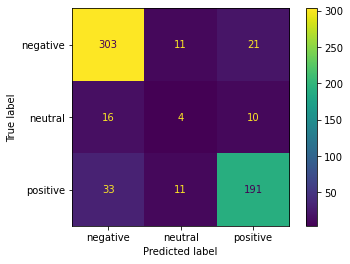

In [25]:
print("Best recall score:", logreg_gridsearch.best_score_.round(3))
print("Optimal parameters:", logreg_gridsearch.best_params_)
plot_confusion_matrix(logreg_gridsearch, X_test, y_test)

Surprisingly, random forest grid search returns a worse result than the original random forest model -- and therefore is also worse than our logistic regression model -- with the default parameters.

In [26]:
rf_gridsearch = GridSearchCV(estimator=rf_pipe, 
                             param_grid=rf_param_grid, 
                             scoring='recall_micro')
rf_gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('smote',
                                        SMOTE(sampling_strategy='not '
                                                                'majority')),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__n_estimators': [10, 50, 100]},
             scoring='recall_micro')

Best recall score: 0.809
Optimal parameters: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__n_estimators': 100}


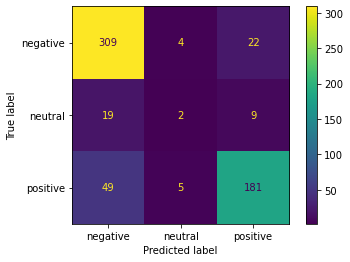

In [27]:
print("Best recall score:", rf_gridsearch.best_score_.round(3))
print("Optimal parameters:", rf_gridsearch.best_params_)
plot_confusion_matrix(rf_gridsearch, X_test, y_test)

## Application

## Conclusion

- Best model was able to predict sentiment with ~83% recall score, ~84% with optimized parameters

### Next Steps

- I would like to implement a recommendation system into my application where users can be recommended games based on whether they liked the games they reviewed (i.e. if a user gave a negative review for ACNH they would receive recommendations based on what was popular among other people who also negatively reviewed ACNH) and genres
- Building on that, I would like to build a database of Switch games. The recommender system would still be present, but for people who prefer to browse, I would want to implement a database that includes details about each game such as trailers, reviews from other sites, etc.
- Multilingual support